In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
#data in and out
input_file = 'online_retail_II.csv'
customer_table= 'Customer.csv'
product_table= 'ProductIntermediate.csv' #after doing this I realised that when making connections in powerbi it's case insensistive like a lookup in excel, need to change some things
product_table_F= 'Product.csv' #this is most recent record for each stock code, not good for powerbi model
full_product_table= 'FullProducts.csv' #full product table, would be used in business exercise to decide which stock code gets which name later on
#would then use that to create a formal product table but still have code as a backup for new products
dates_table = 'Dates.csv' #use to see how often customer orders vs first order

In [3]:
# First Check
df = pd.read_csv(input_file)
df.head(25)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [4]:
#df['Customer ID'] = df['Customer ID'].apply(lambda customer_id: 0 if pd.isna(customer_id) or not customer_id else customer_id) #need these filled in
df['Description'] = df['Description'].apply(lambda desc: 'Blank' if pd.isna(desc) or not desc else desc) #need these filled in
df['Revenue'] = df['Quantity'] * df['Price'] 
df['ReturnFlag'] = df['Invoice'].apply(lambda x: 1 if x.startswith('C') else 0) #data does not say it's case insensitive FYI
df['MonthYear'] = df['InvoiceDate'].str[:7]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date #this needs to be a date for min aggregation later on

In [5]:
#create product table  here, we know from previous DD that the names are not always unique
#we want that to not be the case, need 1-1 map

#the filtering should be done separately as pandas can struggle with boolean conditons it seems
product = df.loc[df['ReturnFlag'] == 0, ['StockCode', 'Description', 'InvoiceDate']].sort_values(['StockCode', 'Description', 'InvoiceDate'])
#don't want return definitions
product = product.loc[(product['Description'].notnull()), ['StockCode', 'Description', 'InvoiceDate']].drop_duplicates() # don't want any NULL values either

#we will retain the most recent description of the product that was not a return, business should provide definitions really
#We're also going to export the list where we have multiple product names in same stock code to investigate and show the business
product[['StockCode', 'Description']].drop_duplicates().to_csv(full_product_table, index=False)
print(f"Data transformed and saved to: {full_product_table}")
product = product.sort_values(['StockCode', 'InvoiceDate'], ascending=[True, False])

Data transformed and saved to: FullProducts.csv


In [6]:
#check to see if there are multiple product descriptions
descCheck = product.groupby('StockCode').agg({'Description': 'nunique'}).reset_index()
descCheck.sort_values(['Description'], ascending=False).head()

,StockCode,Description
283,20713,10
2390,23084,8
662,21181,8
2049,22734,8
1751,22423,8


In [7]:
#get most recent version of each product
firstsold = product[['StockCode', 'InvoiceDate']].groupby('StockCode')['InvoiceDate'].min().reset_index()
firstsold.rename(columns={'InvoiceDate': 'FirstOrdered'}, inplace=True)

In [8]:
#get most recent version of each product
product = product[['StockCode', 'Description']].drop_duplicates(subset=['StockCode'], keep='first') #this is basically a CTE / Row Number in 1 line
product.head()

,StockCode,Description
697034,10002,Blank
69685,10002R,ROBOT PENCIL SHARPNER
1013065,10080,GROOVY CACTUS INFLATABLE
81500,10109,Blank
1048621,10120,DOGGY RUBBER


In [9]:
product.merge(firstsold, on='StockCode').to_csv(product_table, index=False)
print(f"Data transformed and saved to: {product_table}")

Data transformed and saved to: ProductIntermediate.csv


In [10]:
product.merge(firstsold, on='StockCode').head()

,StockCode,Description,FirstOrdered
0,10002,Blank,2009-12-01
1,10002R,ROBOT PENCIL SHARPNER,2009-12-02
2,10080,GROOVY CACTUS INFLATABLE,2009-12-02
3,10109,Blank,2009-12-03
4,10120,DOGGY RUBBER,2009-12-01


In [11]:
#This is the version that will go into the model, will be 1-many with the core table
product['StockCode'] = product['StockCode'].str.upper()
product = product[['StockCode', 'Description']].drop_duplicates(subset=['StockCode'], keep='first') #this is basically a CTE / Row Number in 1 line
product.merge(firstsold, on='StockCode').to_csv(product_table_F, index=False)
print(f"Data transformed and saved to: {product_table_F}")

Data transformed and saved to: Product.csv


In [12]:
#Check to see if country can be associated with customer
countryCheck = df[['Customer ID', 'Country']].drop_duplicates().groupby('Customer ID').agg({'Country': 'nunique'}).reset_index()
countryCheck.sort_values(['Country'], ascending=False).head()

,Customer ID,Country
103,12449.0,2
399,12745.0,2
77,12423.0,2
71,12417.0,2
24,12370.0,2


In [13]:
#Create Customer Table
# group by cusomter id and do aggregations using dictionary method
cust = df[df['Customer ID'].notnull()].groupby('Customer ID')[['Invoice', 'StockCode', 'Quantity', 'InvoiceDate', 'InvoiceDate', 'MonthYear', 'Revenue']].agg({
    'Invoice': 'nunique',
    'StockCode': 'nunique',
    'Quantity': 'sum',
    'InvoiceDate': ['min','max'],
    'MonthYear': 'nunique',
    'Revenue': 'sum'
})

cust.columns = ['Customer Orders', 'Customer Products', 'Customer Products Ordered', 'First Order', 'Last Order', 'Order Months', 'Customer Revenue']
#this is just for appearance as it'll be in the final dashborad and don't want to do in Power BI

# Create AOV column
#Reset the index to make 'Customer ID' a column, mega important
cust['Customer AOV'] = cust['Customer Revenue'] / cust['Customer Orders']
cust = cust.reset_index().sort_values('Customer Revenue', ascending=False)


print(cust.head())

      Customer ID  Customer Orders  Customer Products  \
5756      18102.0              153                384   
2300      14646.0              164                964   
1810      14156.0              202               1446   
2565      14911.0              510               2557   
5104      17450.0               61                148   

      Customer Products Ordered First Order  Last Order  Order Months  \
5756                     187110  2009-12-01  2011-12-09            24   
2300                     365220  2009-12-02  2011-12-08            25   
1810                     163910  2009-12-01  2011-11-30            24   
2565                     143741  2009-12-01  2011-12-08            25   
5104                      81644  2010-09-27  2011-12-01            15   

      Customer Revenue  Customer AOV  
5756         598215.22   3909.903399  
2300         523342.07   3191.110183  
1810         296564.69   1468.142030  
2565         270248.53    529.899078  
5104         233579.39 

In [14]:
#next steps will be to gather an order months %
#for segments (read clustering) we want things that aren't effected by how long the customer has been ordering
dates = pd.read_csv(dates_table)
dates['Date'] = pd.to_datetime(dates['Date']).dt.date
dates.rename(columns={'Date': 'First Order'}, inplace=True)
dates.head()

,First Order,Date ID,Period,Year,Quarter,Half,Month,Week,Day,Day of the Week,Day of the Week n
0,2009-12-01,1,1,2009,4,2,12,49,1,Tuesday,2
1,2009-12-02,2,1,2009,4,2,12,49,2,Wednesday,3
2,2009-12-03,3,1,2009,4,2,12,49,3,Thursday,4
3,2009-12-04,4,1,2009,4,2,12,49,4,Friday,5
4,2009-12-05,5,1,2009,4,2,12,49,5,Saturday,6


In [15]:
dates.tail()

,First Order,Date ID,Period,Year,Quarter,Half,Month,Week,Day,Day of the Week,Day of the Week n
756,2011-12-27,757,25,2011,4,2,12,52,27,Tuesday,2
757,2011-12-28,758,25,2011,4,2,12,52,28,Wednesday,3
758,2011-12-29,759,25,2011,4,2,12,52,29,Thursday,4
759,2011-12-30,760,25,2011,4,2,12,52,30,Friday,5
760,2011-12-31,761,25,2011,4,2,12,52,31,Saturday,6


In [16]:
cust = cust.merge(dates[['First Order','Period']], on='First Order')
cust.rename(columns={'Period': 'First Order Period'}, inplace=True)
cust[['First Order','First Order Period']].drop_duplicates().head()

,First Order,First Order Period
0,2009-12-01,1
1,2009-12-02,1
4,2010-09-27,10
5,2009-12-04,1
7,2010-06-30,7


In [17]:
dates.rename(columns={'First Order': 'Last Order'}, inplace=True)
cust = cust.merge(dates[['Last Order','Period']], on='Last Order')
cust.rename(columns={'Period': 'Last Order Period'}, inplace=True)
cust[['First Order','First Order Period', 'Last Order', 'Last Order Period']].drop_duplicates().head()

,First Order,First Order Period,Last Order,Last Order Period
0,2009-12-01,1,2011-12-09,25
1,2009-12-02,1,2011-12-08,25
2,2009-12-01,1,2011-11-30,24
3,2009-12-01,1,2011-12-08,25
4,2010-09-27,10,2011-12-01,25


In [18]:
lastperiod = cust['Last Order Period'].max()
latestorder = cust['Last Order'].max()

In [19]:
print(f"Last period was {lastperiod} and the latest order was on {latestorder}.The start of the latest period is {latestorder.replace(day=1)}")

Last period was 25 and the latest order was on 2011-12-09.The start of the latest period is 2011-12-01


In [20]:
#here we will say that when we get the % we don't include current month (mostly) unless the customer has already ordered
def orderMonths(df, lastperiod):
    conditions = [
        (latestorder.day > 28),
        (df['First Order Period'] == lastperiod),
        (df['Last Order Period'] == lastperiod),
        True
    ]
    choices = [
        df['Order Months'] / (lastperiod - df['First Order Period'] + 1), #+ 1 is to account for this month
        1,
        df['Order Months'] / (lastperiod - df['First Order Period'] +1),
        df['Order Months'] / (lastperiod - 1 - df['First Order Period'] +1) #we're not counting this period in the maths
        #so the last period is changed to be last month
    ]
    return np.select(conditions, choices, default=np.nan)

cust['Order Months %'] = orderMonths(cust, lastperiod) * 100
cust.sort_values(['Order Months %'], ascending=False).head()

,Customer ID,Customer Orders,Customer Products,Customer Products Ordered,First Order,Last Order,Order Months,Customer Revenue,Customer AOV,First Order Period,Last Order Period,Order Months %
3334,13040.0,2,38,355,2011-11-06,2011-12-01,2,676.99,338.495,24,25,100.0
2442,15088.0,3,53,457,2011-10-03,2011-11-18,2,1140.27,380.090,23,24,100.0
5253,17600.0,1,13,144,2011-11-22,2011-11-22,1,161.67,161.670,24,24,100.0
5240,14354.0,2,9,210,2011-11-09,2011-12-04,2,163.62,81.810,24,25,100.0
2356,16800.0,1,148,540,2011-11-28,2011-11-28,1,1201.49,1201.490,24,24,100.0


In [21]:
cust.sort_values(['Order Months %'], ascending=False)[500:550:1]

,Customer ID,Customer Orders,Customer Products,Customer Products Ordered,First Order,Last Order,Order Months,Customer Revenue,Customer AOV,First Order Period,Last Order Period,Order Months %
1646,17554.0,5,58,1763,2011-07-14,2011-12-08,5,1952.45,390.490000,20,25,83.333333
255,14755.0,30,220,4366,2009-12-03,2011-11-30,20,9851.45,328.381667,1,24,83.333333
2228,16929.0,7,51,929,2011-07-07,2011-12-06,5,1295.39,185.055714,20,25,83.333333
407,17231.0,35,510,3720,2009-12-07,2011-11-27,20,7091.07,202.602000,1,24,83.333333
406,17965.0,33,590,4499,2009-12-14,2011-11-02,20,7117.78,215.690303,1,24,83.333333
2448,16989.0,6,7,1233,2011-07-12,2011-12-02,5,1133.25,188.875000,20,25,83.333333
3212,13575.0,5,41,449,2011-06-16,2011-11-16,5,732.07,146.414000,19,24,83.333333
886,17173.0,9,36,1121,2011-07-31,2011-12-04,5,3755.65,417.294444,20,25,83.333333
307,14709.0,27,105,4138,2009-12-05,2011-11-24,20,8866.48,328.388148,1,24,83.333333
611,12708.0,30,130,2466,2009-12-18,2011-11-10,20,5118.16,170.605333,1,24,83.333333


In [22]:
cust.drop(['First Order Period','Last Order Period'], axis=1).to_csv(customer_table, index=False)
print(f"Data transformed and saved to: {customer_table}")

Data transformed and saved to: Customer.csv


In [23]:
cust['Customer Revenue'].agg(['sum','min','median','max'])
#show that the total isn't the 1.9m

sum       1.664829e+07
min      -2.511109e+04
median    8.439700e+02
max       5.982152e+05
Name: Customer Revenue, dtype: float64

In [24]:
print(cust.groupby('Customer Orders')[['Customer Revenue','Customer AOV']].agg('median').head(20))
#initial thoughts on categorisation are it's not super easy. Should cluster into 4 categories based on high and low value of orders and AOV imo
#one for later

                 Customer Revenue  Customer AOV
Customer Orders                                
1                         211.950    211.950000
2                         436.680    218.340000
3                         666.280    222.093333
4                         888.705    222.176250
5                        1142.305    228.461000
6                        1267.650    211.275000
7                        1626.215    232.316429
8                        2005.060    250.632500
9                        2066.140    229.571111
10                       2396.110    239.611000
11                       2612.190    237.471818
12                       3032.310    252.692500
13                       3094.110    238.008462
14                       3512.790    250.913571
15                       4217.160    281.144000
16                       3754.710    234.669375
17                       3828.550    225.208824
18                       4592.100    255.116667
19                       4783.930    251

In [25]:
print(cust.groupby('Customer Orders')[['Customer Revenue','Customer AOV']].agg('median').tail(20))
#initial thoughts on categorisation are it's not super easy. Should cluster into 4 categories based on high and low value of orders and AOV imo
#one for later

                 Customer Revenue  Customer AOV
Customer Orders                                
102                      2979.090     29.206765
103                     34639.450    336.305340
107                     39742.990    371.429813
120                     15482.740    129.022833
125                     82687.190    661.497520
129                     37948.610    294.175271
135                     50852.852    376.687793
138                    117643.535    852.489384
146                     61110.540    418.565342
153                    598215.220   3909.903399
159                     55703.130    350.334151
164                    357083.795   2177.340213
190                     25774.540    135.655474
202                    296564.690   1468.142030
247                    113214.190    458.357045
259                     30094.380    116.194517
270                    113513.070    420.418778
289                     69516.190    240.540450
365                     49970.130    136

In [26]:
print(cust.groupby('Customer Orders')[['Customer Revenue','Customer AOV']].agg('mean').head(20))
#initial thoughts on categorisation are it's not super easy. Should cluster into 4 categories based on high and low value of orders and AOV imo
#one for later

                 Customer Revenue  Customer AOV
Customer Orders                                
1                      269.437921    269.437921
2                      568.582345    284.291173
3                      819.708201    273.236067
4                     1136.220270    284.055067
5                     1424.927977    284.985595
6                     1627.298861    271.216477
7                     1980.844055    282.977722
8                     2624.095712    328.011964
9                     2706.646272    300.738475
10                    2997.002833    299.700283
11                    3301.910561    300.173687
12                    3984.629427    332.052452
13                    3957.313626    304.408740
14                    4200.370559    300.026469
15                    4915.638000    327.709200
16                    4835.058113    302.191132
17                    5083.956686    299.056276
18                    5533.323922    307.406885
19                    6311.952500    332

In [27]:
print(cust.groupby('Customer Orders')[['Customer Revenue','Customer AOV']].agg('mean').tail(20))
#initial thoughts on categorisation are it's not super easy. Should cluster into 4 categories based on high and low value of orders and AOV imo
#one for later

                 Customer Revenue  Customer AOV
Customer Orders                                
102                      2979.090     29.206765
103                     34639.450    336.305340
107                     39742.990    371.429813
120                     15482.740    129.022833
125                     82687.190    661.497520
129                     37948.610    294.175271
135                     50852.852    376.687793
138                    117643.535    852.489384
146                     61110.540    418.565342
153                    598215.220   3909.903399
159                     55703.130    350.334151
164                    357083.795   2177.340213
190                     25774.540    135.655474
202                    296564.690   1468.142030
247                    113214.190    458.357045
259                     30094.380    116.194517
270                    113513.070    420.418778
289                     69516.190    240.540450
365                     49970.130    136

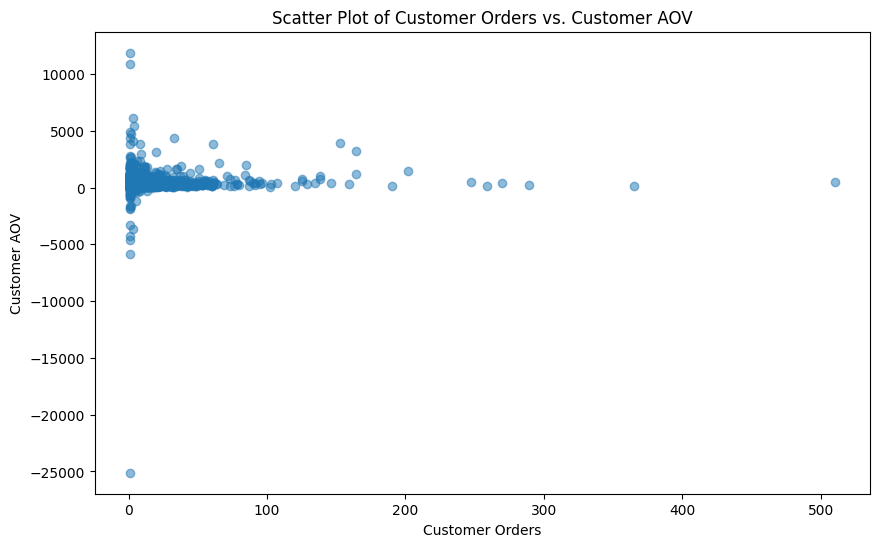

In [28]:
# check customer distribution
plt.figure(figsize=(10, 6))
plt.scatter(cust['Customer Orders'], cust['Customer AOV'], alpha=0.5)
plt.title('Scatter Plot of Customer Orders vs. Customer AOV')
plt.xlabel('Customer Orders')
plt.ylabel('Customer AOV')
plt.show()

In [29]:
#start of customer segmentation, first rule would be we don't want any - revenue figures
cust = cust[cust['Customer Revenue'] > 0]

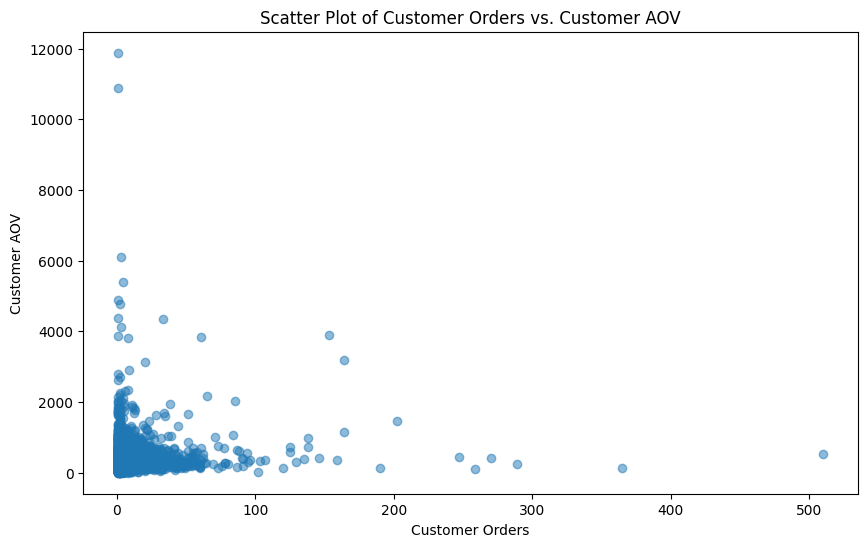

In [30]:
# Check distribution again, not expecting perfection and a pretty version
plt.figure(figsize=(10, 6))
plt.scatter(cust['Customer Orders'], cust['Customer AOV'], alpha=0.5)
plt.title('Scatter Plot of Customer Orders vs. Customer AOV')
plt.xlabel('Customer Orders')
plt.ylabel('Customer AOV')
plt.show()

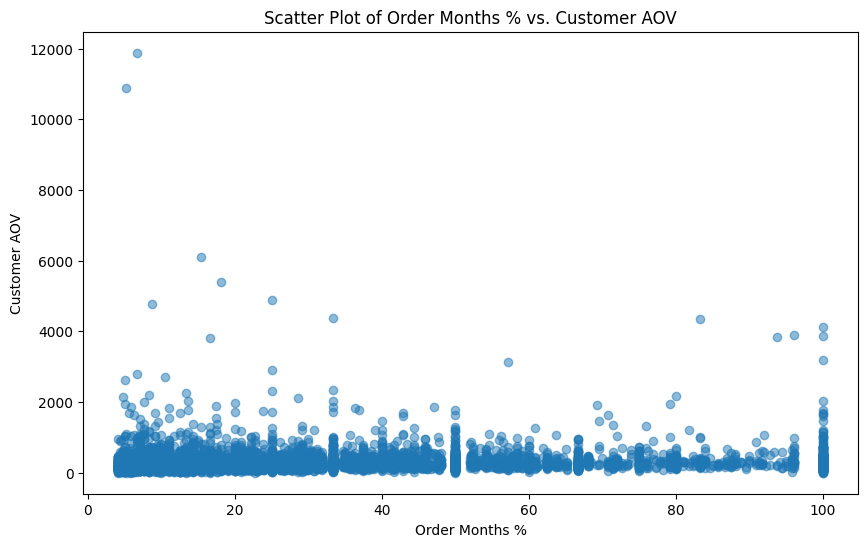

In [31]:
# Now use the AOV vs Order Month % as its not effected by time
plt.figure(figsize=(10, 6))
plt.scatter(cust['Order Months %'], cust['Customer AOV'], alpha=0.5)
plt.title('Scatter Plot of Order Months % vs. Customer AOV')
plt.xlabel('Order Months %')
plt.ylabel('Customer AOV')
plt.show()

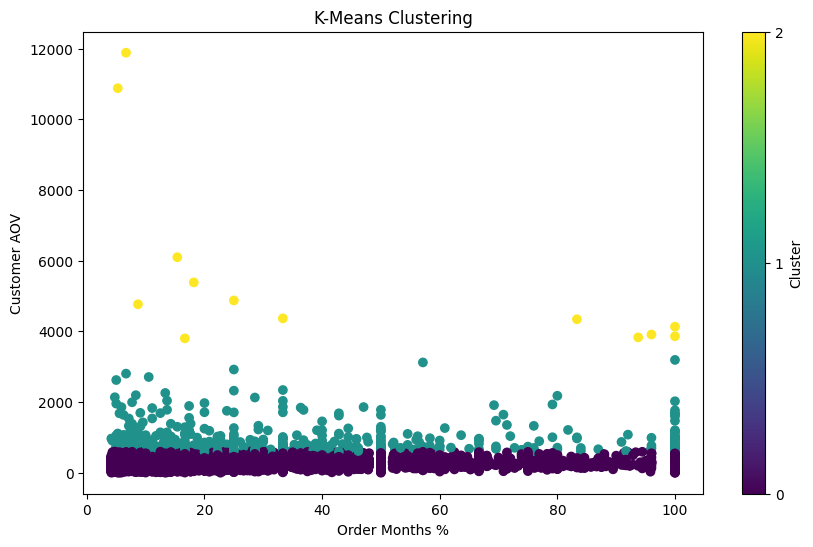

In [32]:
# create a specific data set for the k means clustering
X = cust[['Order Months %', 'Customer AOV', 'Last Order Period']]
# Remove New Customers
#X = X[(X['Last Order Period'] < lastperiod - 2)].drop(['Last Order Period'], axis=1)

# Instantiate the K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the original data
cust['Cluster'] = labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(cust['Order Months %'], cust['Customer AOV'], c=labels, cmap='viridis')
plt.xlabel('Order Months %')
plt.ylabel('Customer AOV')
plt.title('K-Means Clustering')
plt.colorbar(ticks=range(4), label='Cluster')
plt.show()

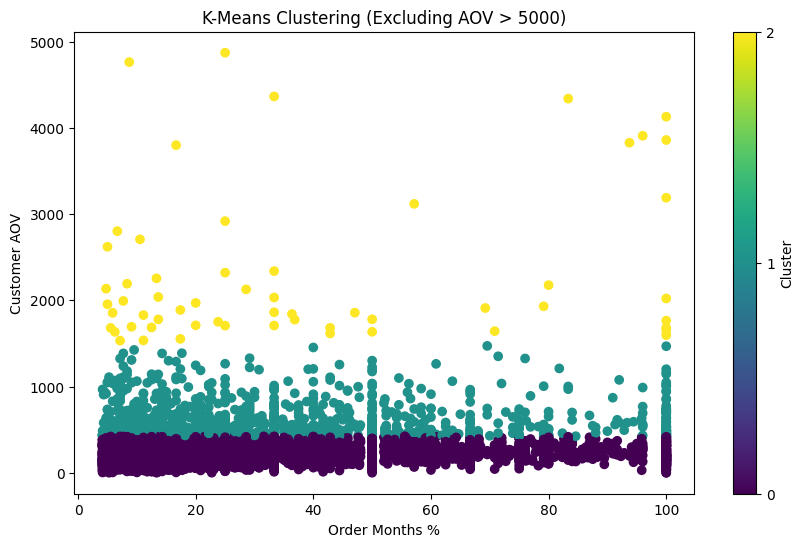

In [33]:
# Attempt 2, this time we will remove the outliers to see how that looks
X = cust[['Order Months %', 'Customer AOV']]
X = X[(X['Customer AOV'] <= 5000)]

# Instantiate the K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the original data
X['Cluster'] = labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X['Order Months %'], X['Customer AOV'], c=labels, cmap='viridis')
plt.xlabel('Order Months %')
plt.ylabel('Customer AOV')
plt.title('K-Means Clustering (Excluding AOV > 5000)')
plt.colorbar(ticks=range(4), label='Cluster')
plt.show()

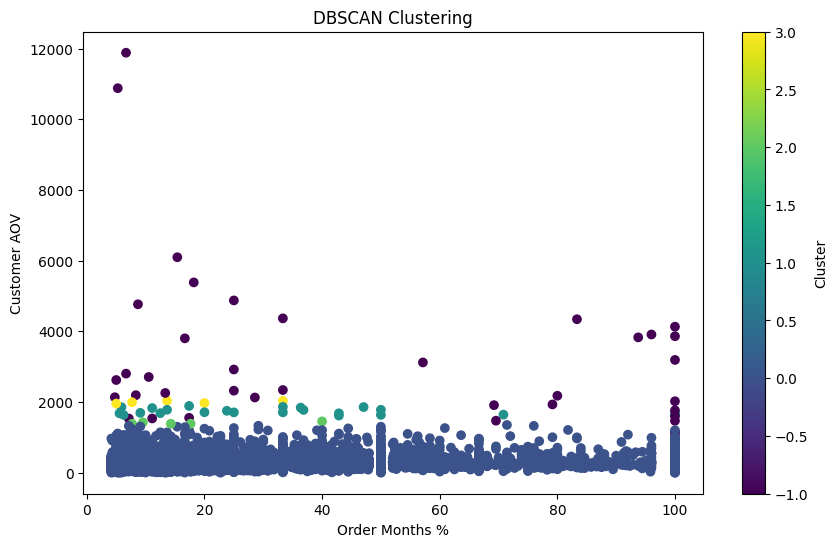

In [34]:
#Option 3, use dbscan (Density-Based Spatial Clustering of Applications with Noise)
#this is supposedly better with outliers and might have helped with odd shapes

from sklearn.cluster import DBSCAN

# Load your data into a Pandas DataFrame
data = pd.read_csv(customer_table)
data = data[(data['Customer Revenue'] > 0) #& (data['Customer AOV'] <= 5000) & (data['Order Months %'] <= 250)
]

# Extract the features: Order Months % and Customer AOV
X = data[['Order Months %', 'Customer AOV']]

# Instantiate the DBSCAN model
dbscan = DBSCAN(eps=50, min_samples=5)

# Fit the model to the data
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the original data
data['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['Order Months %'], data['Customer AOV'], c=data['Cluster'], cmap='viridis')
plt.xlabel('Order Months %')
plt.ylabel('Customer AOV')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster')
plt.show()

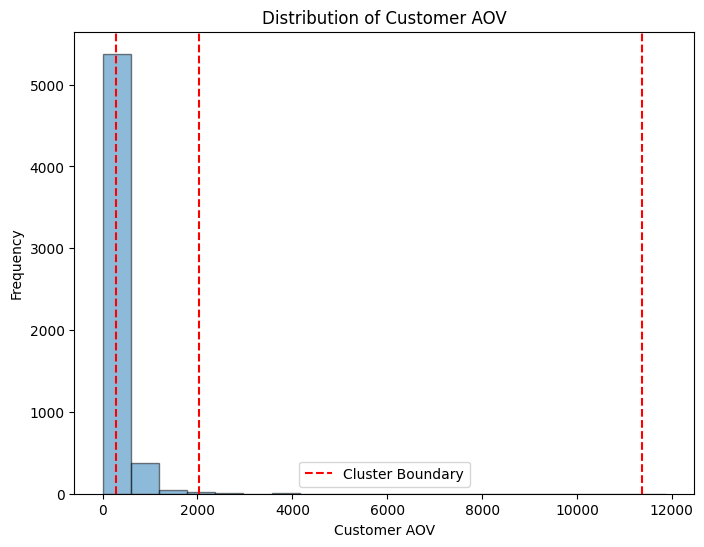

In [35]:
#Option 4, as the better k means output segmented largely around AOV lets just have AOV segments

# reread in original data
cust = pd.read_csv(customer_table)
cust = cust[cust['Customer Revenue'] > 0]

# Extract the feature: Customer AOV
X = cust[['Customer AOV']]

# Instantiate the K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the original data
cust['Cluster'] = labels

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.hist(cust['Customer AOV'], bins=20, edgecolor='black', alpha=0.5)
plt.title('Distribution of Customer AOV')
plt.xlabel('Customer AOV')
plt.ylabel('Frequency')

# Add vertical lines to mark cluster boundaries
cluster_centers = kmeans.cluster_centers_.flatten()
for center in cluster_centers:
    plt.axvline(center, color='r', linestyle='--', label='Cluster Boundary' if center == cluster_centers[0] else None)

plt.legend()
plt.show()

In [36]:
# Get the cluster centers (boundaries)
cluster_centers = kmeans.cluster_centers_.flatten()

# Print the cluster boundaries
print("Cluster Boundaries (AOV):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: {center:.2f}")

Cluster Boundaries (AOV):
Cluster 0: 278.07
Cluster 1: 2025.76
Cluster 2: 11379.01


In [37]:
# Function to apply customer segmentation
def assign_customer_segment(aov):
    if aov < 0:
        return ""
    elif aov < cluster_centers[0]:
        return "Low AOV"
    elif aov < cluster_centers[1]:
        return "Medium AOV"
    else:
        return "High AOV"

# Apply the function to the data, we get the data one last time as we need to include the customers we didn't during clustering
cust = pd.read_csv(customer_table)
cust['Customer Segment'] = cust['Customer AOV'].apply(assign_customer_segment)

# Print the first few rows of the data with the new 'Customer Segment' column
print("\nCustomer Segments:")
print(cust[['Customer AOV', 'Customer Segment']].head())


Customer Segments:
   Customer AOV Customer Segment
0   3909.903399         High AOV
1   3191.110183         High AOV
2   1468.142030       Medium AOV
3    529.899078       Medium AOV
4   3829.170328         High AOV


In [38]:
print(cust.head())

   Customer ID  Customer Orders  Customer Products  Customer Products Ordered  \
0      18102.0              153                384                     187110   
1      14646.0              164                964                     365220   
2      14156.0              202               1446                     163910   
3      14911.0              510               2557                     143741   
4      17450.0               61                148                      81644   

  First Order  Last Order  Order Months  Customer Revenue  Customer AOV  \
0  2009-12-01  2011-12-09            24         598215.22   3909.903399   
1  2009-12-02  2011-12-08            25         523342.07   3191.110183   
2  2009-12-01  2011-11-30            24         296564.69   1468.142030   
3  2009-12-01  2011-12-08            25         270248.53    529.899078   
4  2010-09-27  2011-12-01            15         233579.39   3829.170328   

   Order Months % Customer Segment  
0           96.00        

In [39]:
cust.to_csv(customer_table, index=False)
print(f"Data transformed and saved to: {customer_table}")

Data transformed and saved to: Customer.csv
